# DBSCAN with Scikit-Learn

### Set up and generate data

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
%matplotlib inline

In [2]:
X, label = make_moons(n_samples=200, noise=0.1, random_state=19)
print X[:5,]

[[ 0.28171457  0.91044406]
 [ 0.8389241  -0.53005338]
 [ 0.40915474  0.80944352]
 [-0.98415213  0.13142155]
 [ 1.15919021  0.4910425 ]]


### Train the model

In [3]:
# model = DBSCAN?
model = DBSCAN(eps=0.25, min_samples=12).fit(X)
print model

DBSCAN(algorithm='auto', eps=0.25, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=12, n_jobs=None, p=None)


In [4]:
Counter(model.labels_)

Counter({-1: 1, 0: 100, 1: 99})

### Plot the cluster in feature space

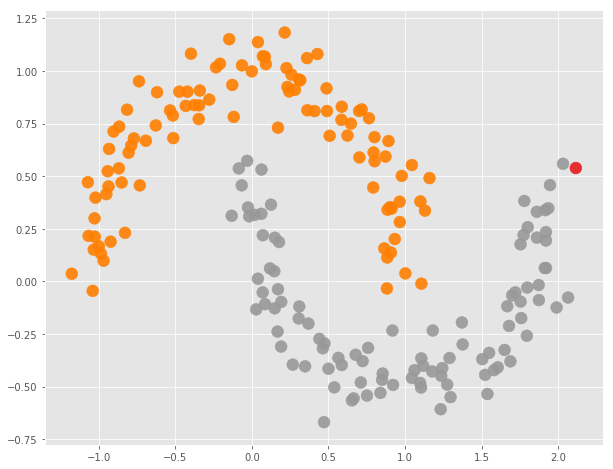

In [5]:
fig, ax = plt.subplots(figsize=(10, 8))
sctr = ax.scatter(X[:, 0], X[:, 1], c=model.labels_, s=140, alpha=0.9,
                 cmap=plt.cm.Set1)
fig.show()

# DBSCAN with GraphLab

In [6]:
import graphlab as gl

sf = gl.SFrame(X)
sf = sf.unpack('X1')
model2 = gl.dbscan.create(sf, radius=0.25, min_core_neighbors=10)

[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1554080702.log


This non-commercial license of GraphLab Create for academic use is assigned to rubychous@gmail.com and will expire on March 29, 2020.


Starting brute force nearest neighbors model training.

Starting blockwise similarity graph construction.

max rows per data block: 8190

number of reference data blocks: 8

+---------+-------------+--------------+

[INFO] graphlab.toolkits.clustering.dbscan: Identifying noise points and core points.


| # Pairs | % Complete. | Elapsed Time |

+---------+-------------+--------------+

[INFO] graphlab.toolkits.clustering.dbscan: Constructing the core point similarity graph.


| 5000    | 22.2222     | 486us        |

| 22500   | 100         | 1.435ms      |

+---------+-------------+--------------+

+-----------------------------+

| Number of components merged |

+-----------------------------+

| 1056                        |

| 0                           |

+-----------------------------+

[INFO] graphlab.toolkits.clustering.dbscan: Processing boundary points.


In [7]:
model2.summary()

Class                                    : DBSCANModel

Schema
------
Number of examples                       : 200
Number of feature columns                : 2
Max distance to a neighbor (radius)      : 0.25
Min number of neighbors for core points  : 10
Number of distance components            : 1

Training summary
----------------
Total training time (seconds)            : 1.303
Number of clusters                       : 2

Accessible fields
-----------------
cluster_id                              : Cluster label for each row in the input dataset.


### Access cluster labels and instance types

In [8]:
model2['cluster_id']

row_id,cluster_id,type
110,1,core
96,1,core
136,0,core
175,1,core
50,0,core
68,1,core
47,0,core
155,0,core
8,0,core
5,1,core


### Plot by instances

In [9]:
sf_out = sf.add_row_number('row_id')
sf_out = sf_out.join(model2['cluster_id'], on='row_id', how='left')

In [10]:
type_map = {k: v for v, k in enumerate(sf_out['type'].unique())}
sf_out['type_code'] = sf_out['type'].apply(lambda x: type_map[x])

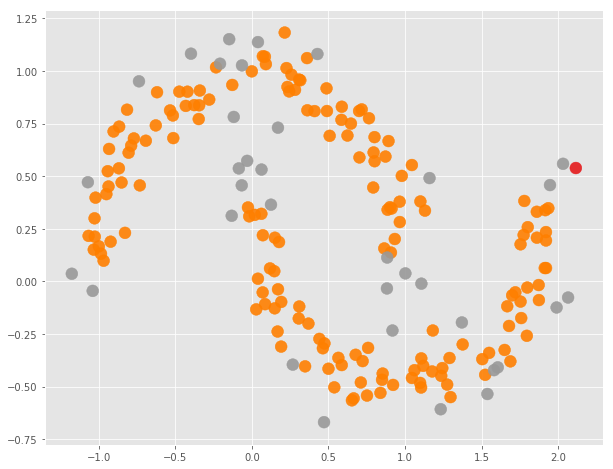

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(sf_out['X1.0'], sf_out['X1.1'], c=sf_out['type_code'],
           s=140, alpha=0.9, cmap=plt.cm.Set1)
fig.show()

# Document Deduplication with DBSCAN

### download dataset

In [12]:
import os
if os.path.exists('wikipedia_w0'):
    wiki = gl.SFrame('wikipedia_w0')
else:
    wiki = gl.SFrame.read_csv('https://static.turi.com/datasets/wikipedia/raw/w0', header=False)
    wiki.save('wikipedia_w0')

In [13]:
#wiki = gl.SFrame('wikipedia_w0')
wiki = wiki.add_row_number('row_id')
wiki.print_rows(5, max_column_width=70, max_row_width=90)

+--------+-----------------------------------------------------------------------+
| row_id |                                   X1                                  |
+--------+-----------------------------------------------------------------------+
|   0    | anarchism the following sources cite anarchism as a political phil... |
|   1    | alaska alaska was purchased from the russian empire on march 30 18... |
|   2    | aruba ast utc04 aruba which has no administrative subdivisions is ... |
|   3    | asteroidsvideogame the game was conceived by lyle rains and progra... |
|   4    | ancientegypt its history occurred in a series of stable kingdoms s... |
+--------+-----------------------------------------------------------------------+
[72270 rows x 2 columns]



### Feature Engineering

### Convert to bag-of-words

In [14]:
wiki['words'] = gl.text_analytics.count_words(wiki['X1'])
wiki[['words']].print_rows(5, max_column_width=80)

+---------------------------------------------------------------------------------+
|                                      words                                      |
+---------------------------------------------------------------------------------+
| {'writings': 3, 'four': 2, 'andre': 1, 'prefix': 1, 'consists': 1, 'aggressi... |
| {'limited': 3, 'todays': 1, 'colleges': 1, 'four': 6, 'nursery': 1, 'asian':... |
| {'mardi': 1, 'convert500': 1, 'all': 5, 'chinese': 1, 'saying': 1, 'series':... |
| {'all': 3, 'code': 1, 'rom': 2, 'asteroids': 36, 'four': 1, 'circuitry': 2, ... |
| {'writings': 2, '3200bc': 2, 'similarity': 1, 'surrounding': 2, 'destroyed':... |
+---------------------------------------------------------------------------------+
[72270 rows x 1 columns]



### Remove stop-words

In [15]:
wiki['words'] = wiki['words'].dict_trim_by_keys(gl.text_analytics.stopwords(),
                                                exclude=True)

### Create Model

In [16]:
# dbscan = gl.dbscan.create(wiki, features=['words'],
#                          distance='jaccard', radius=0.6,
#                          min_core_neighbors=3, verbose=False)

# dbscan.save('wiki_dbscan.gl')
dbscan = gl.load_model('wiki_dbscan.gl')
dbscan.summary()

Class                                    : DBSCANModel

Schema
------
Number of examples                       : 72270
Number of feature columns                : 1
Max distance to a neighbor (radius)      : 0.6
Min number of neighbors for core points  : 3
Number of distance components            : 1

Training summary
----------------
Total training time (seconds)            : 730.1936
Number of clusters                       : 206

Accessible fields
-----------------
cluster_id                              : Cluster label for each row in the input dataset.


In [17]:
dbscan['cluster_id'].show()

Canvas is accessible via web browser at the URL: http://localhost:49454/index.html
Opening Canvas in default web browser.


### Explore the cluster

In [18]:
wiki = wiki.join(dbscan['cluster_id'], on='row_id', how='left')

In [19]:
wiki[wiki['cluster_id'] == 50][['X1']].print_rows(5, max_row_width=80,
                                                  max_column_width=80)

+---------------------------------------------------------------------------------+
|                                        X1                                       |
+---------------------------------------------------------------------------------+
| bielovce in historical records the village was first mentioned in 1138 the v... |
| slovenskkaja in historical records the village was first mentioned in 1334 t... |
| daa in historical records the village was first mentioned in 1222 the villag... |
| dolnbreznica in historical records the village was first mentioned in 1388 t... |
| pavlovcevranovnadtopoudistrict in historical records the village was first m... |
+---------------------------------------------------------------------------------+
[50 rows x 1 columns]

